In [1]:
import re
import pandas as pd
pd.options.mode.chained_assignment = None
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import string
from datetime import datetime
from utils.database_util import DatabaseUtil
from matplotlib import pyplot as plt
import seaborn as sns
import quandl
from sklearn import preprocessing
%matplotlib inline
pd.options.display.float_format = '{:,.0f}'.format
%config IPCompleter.greedy=True

# Data Cleaning

In [2]:
# connect to the sqlite3 db file, utilizing the customized module
DBUtil = DatabaseUtil()
conn = DBUtil.get_conn()

* clean tweets data

In [3]:
df_t = pd.read_sql('select * from tweets', conn)

In [4]:
# tweets df before cleaning
df_t.sample(5)

,id,author,tweet,time,type
16333,1055548506276999168,condobusiness,Mortgage financing stress test makes the grade...,2018-10-25 19:55:49,realtor
19327,1086647023917506563,IBDinvestors,"If you don’t learn from your trading mistakes,...",2019-01-19 15:30:14,biznews
29967,1126630452532584448,WSJ,News Corp reported a sharp increase in revenue...,2019-05-09 23:30:06,biznews
11921,1003763325556215809,RealEstateProCA,Heavyweight global investors convening in Toro...,2018-06-04 22:20:00,realtor
29462,1126354875208671232,WSJ,Pay for executives and senior managers is low ...,2019-05-09 05:15:03,biznews


In [5]:
# twitter text processing and cleaning function
def process_words(raw, remove_punc=False, stem=False):
    link_pattern = [
        r'(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*$',
    ]
    clean = raw.lower().strip()
    for ptn in link_pattern:
        clean = re.sub(ptn, '', clean)
    if remove_punc:
        nopunc = [c for c in clean if c not in string.punctuation]
        raw = ''.join(nopunc)

    stopwords_list = []
    stopwords_list_en = set(stopwords.words('english'))
    stopwords_list_fr = set(stopwords.words('french'))
    stopwords_list.extend(stopwords_list_en)
    stopwords_list.extend(stopwords_list_fr)
   
    nostop = [w for w in raw.split() if w.lower() not in stopwords_list]
    if stem:
        stemmer = PorterStemmer()
        return ' '.join([stemmer.stem(t) for t in nostop])
    else:
        return ' '.join(nostop)

In [6]:
df_t['tweet_clean'] = df_t['tweet'].apply(lambda t: process_words(t, remove_punc=True))
# transform tweet timestamp from string format to datetime
df_t['date'] = df_t['time'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
df_t['date'] = df_t['date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))
df_t.drop(['time','tweet'],axis = 1, inplace=True)

In [7]:
# tweets df after cleaning
df_t.sample(5)

,id,author,type,tweet_clean,date
4743,860471655478566912,HOMESMagazineON,realtor,editors choice madisongroup inspired living fr...,2017-05-05
39967,1129865019578101760,YahooFinance,biznews,come meet physique57 cofounder ceo jennifer ma...,2019-05-18
32934,1128231277793021956,barronsonline,biznews,alibaba reports earnings tomorrow here’s expect,2019-05-14
17586,1067581414571425792,HOMESMagazineON,realtor,second series gm developments oshawa means eco...,2018-11-28
13062,1014481514757853185,RECOhelps,realtor,salespeople brokers new reco registrar’s bulle...,2018-07-04


In [8]:
# subsetting the dataframe, grouping by tweets categories
news = df_t[df_t['type'] == 'biznews']
realtor = df_t[df_t['type'] == 'realtor']
searched = df_t[df_t['type'] == 'search']

* clean RealMaster data

In [9]:
df_praw = pd.read_sql('select * from realmaster', conn)

In [10]:
# web df before cleaning
df_praw.sample(5)

,listID,address,ask,city,proptype
997,N4399159,56 Wales Ave Markham Ontario L3P2C5,945000,Markham,Bungalow
3151,C4451420,5418 Yonge St Toronto Ontario M2N6X4,718000,Toronto,Apartment
3061,C4448509,170 Newton Dr Toronto Ontario M2M2N7,1668000,Toronto,Bungalow
3116,W4452211,2 Dovehaven Crt Toronto Ontario M3N2G6,749000,Toronto,Bungalow
1492,W4442412,510 Curran Pl Mississauga Ontario L5B 0J8,445000,Mississauga,Apartment


In [11]:
def get_postal(s):
    p = re.findall('[A-Z]\d[A-Z]\s?\d[A-Z]\d',s)
    if len(p) > 0:
        return p[0].replace(' ','')
    else:
        return None

In [12]:
df_p = df_praw.copy()

In [13]:
# spin out postal code
df_p['postal'] = df_p['address'].apply(lambda a: get_postal(a))

In [14]:
# clean city name ('Richmond%20Hill')
df_p['city'] = df_p['city'].apply(lambda c:c.replace('%20',' '))

In [15]:
# spin street address out of original raw format
def spin_address(df,col1,col2):
    df['bind'] = df[[col1,col2]].apply(tuple,axis=1)
    df['street'] = df['bind'].apply(lambda t: t[0].split(t[1])[0])
    new_df = df[['listID','proptype','ask','street','city','postal']]
    return new_df

In [16]:
df_p = spin_address(df_p,'address','city')

In [17]:
# web df after cleaning
df_p.sample(5)

,listID,proptype,ask,street,city,postal
2016,O4431656,Bungalow,859000,394 St. Augustine Dr,Oakville,L6K3E8
162,W4449554,Detached,979000,2370 Emerson Dr,Burlington,L7L7G6
1448,W4450401,Apartment,599900,310 Burnhamthorpe Rd W,Mississauga,L5B4P9
1145,W4390318,Detached,1139000,711 Dolby Cres,Milton,L9T5L8
2654,N4426786,Bungalow,1399000,54 Dunn Dr,Richmond Hill,L4E3H8


* clean and filter CMHC data

In [18]:
# Canadian Mortgage and Housing Corporation - Average, Median and Price Percentiles for Unabsorbed Homeowner and Condominium Units (Ontario)
cmhc_raw = pd.read_sql('select * from cmhc',con=conn)

In [19]:
#CMHC data before cleaning
cmhc_raw.sample(5)

,Date,1st 20%,2nd 40%,3rd 60%,4th 80%,Median,Average,Units
310,2015-11-30 00:00:00.000000,"330,000","400,000","500,000","866,000","450,000","750,987","1,336"
154,2002-11-30 00:00:00.000000,"180,000","210,000","240,000","300,000","220,000","254,656","1,922"
180,2005-01-31 00:00:00.000000,"220,000","280,000","340,000","415,000","305,000","359,777","1,605"
142,2001-11-30 00:00:00.000000,"175,000","200,000","230,000","295,000","210,000","259,513","1,706"
156,2003-01-31 00:00:00.000000,"180,000","210,000","250,000","305,000","230,000","263,168","1,697"


In [20]:
cmhc_raw['Date'] = cmhc_raw['Date'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
cmhc_raw['Date'] = cmhc_raw['Date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))

In [21]:
cmhc_stat = cmhc_raw[cmhc_raw['Date']>= datetime(2019,1,1)]

In [22]:
# after cleaning and filter
cmhc_stat

,Date,1st 20%,2nd 40%,3rd 60%,4th 80%,Median,Average,Units
347,2019-01-31,"440,000","555,000","670,000","1,260,000","620,000","928,256","1,413"
348,2019-02-28,"440,000","555,000","670,000","1,100,000","620,000","899,072","1,460"
349,2019-03-31,"450,000","575,000","690,000","1,125,000","630,000","924,375","1,471"
350,2019-04-30,"465,000","585,000","700,000","1,330,000","645,000","971,201","1,383"


# Exploratory Analysis

## Sentiment

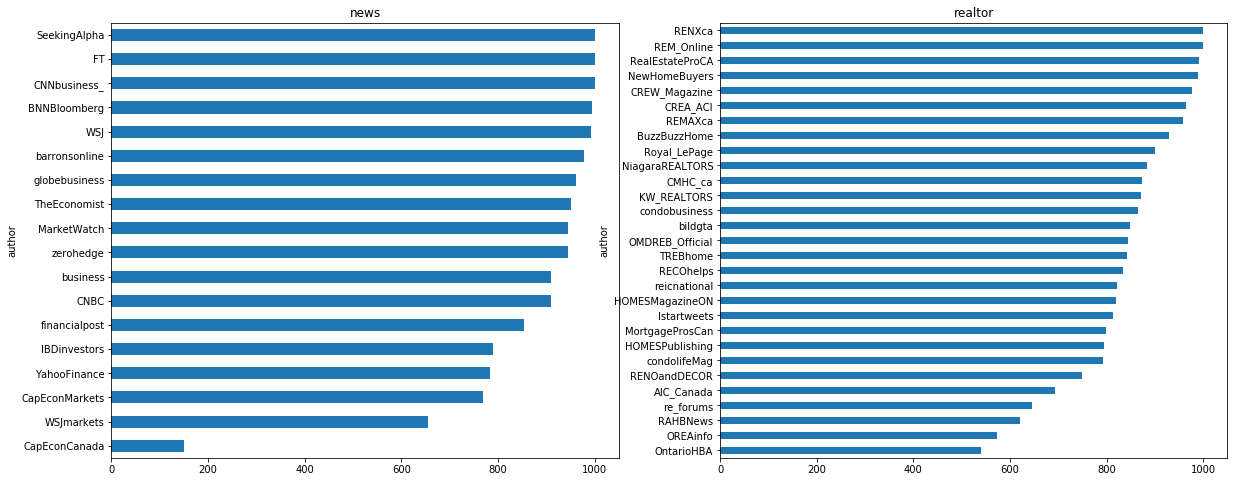

In [23]:
# count the number of tweets collected from each news outlet
cntfig = plt.figure(figsize=(20,8))
f1 = cntfig.add_subplot(121)
f1 = news.groupby('author')['tweet_clean'].count().sort_values().plot(kind='barh')
f2 = cntfig.add_subplot(122)
f2 = realtor.groupby('author')['tweet_clean'].count().sort_values().plot(kind='barh')
axes = cntfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

In [24]:
def find_sent(df):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['tweet_clean'].apply(lambda t: analyzer.polarity_scores(t)['compound'])
    focus = df[['author','date','tweet_clean','sentiment']]
    focus = df[['author','date','tweet_clean','sentiment']]
    filter_time = focus['date'] >= datetime(2019,1,1)
    recent = focus[filter_time].set_index('date')
    return recent

In [25]:
news_recent = find_sent(news)
realtor_recent = find_sent(realtor)
searched_recent = find_sent(searched)

In [26]:
def sent_trend(df):
    grouper = df.groupby(pd.Grouper(freq='M'))
    groupby_month = grouper.mean().reset_index()
    f = plt.scatter(x=groupby_month['date'],y=groupby_month['sentiment'])
    return f

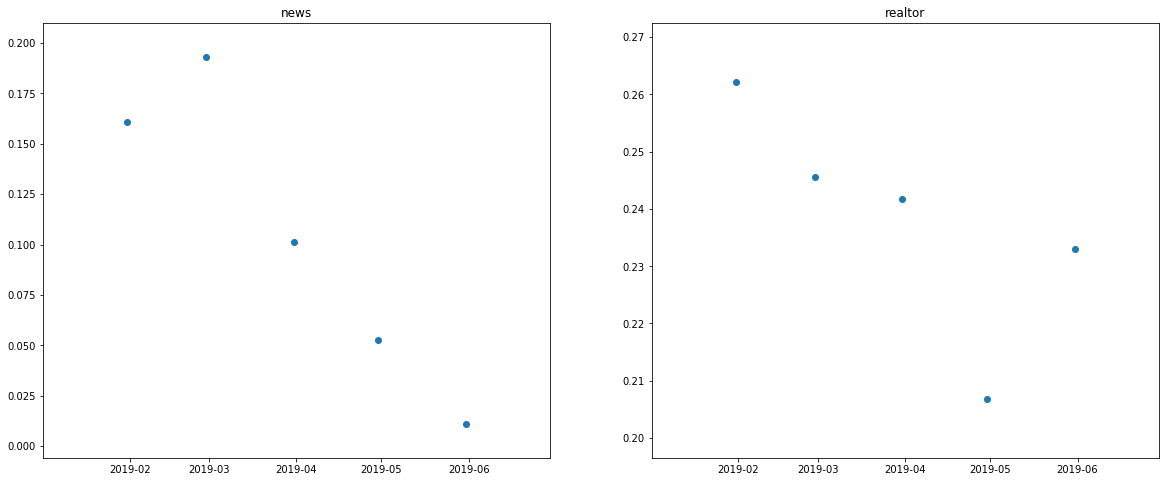

In [27]:
trendfig = plt.figure(figsize=(20,8))
fn = trendfig.add_subplot(121)
fn = sent_trend(news_recent)
fr = trendfig.add_subplot(122)
fr = sent_trend(realtor_recent)
axes = trendfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

In [28]:
def sent_ingroup(df):
    groupby_author = df.groupby('author').mean().reset_index().sort_values('sentiment')
#     f = groupby_author.plot(x='author',kind='barh', figsize = (8,6))
    f = plt.barh(groupby_author['author'], groupby_author['sentiment'])
    return f

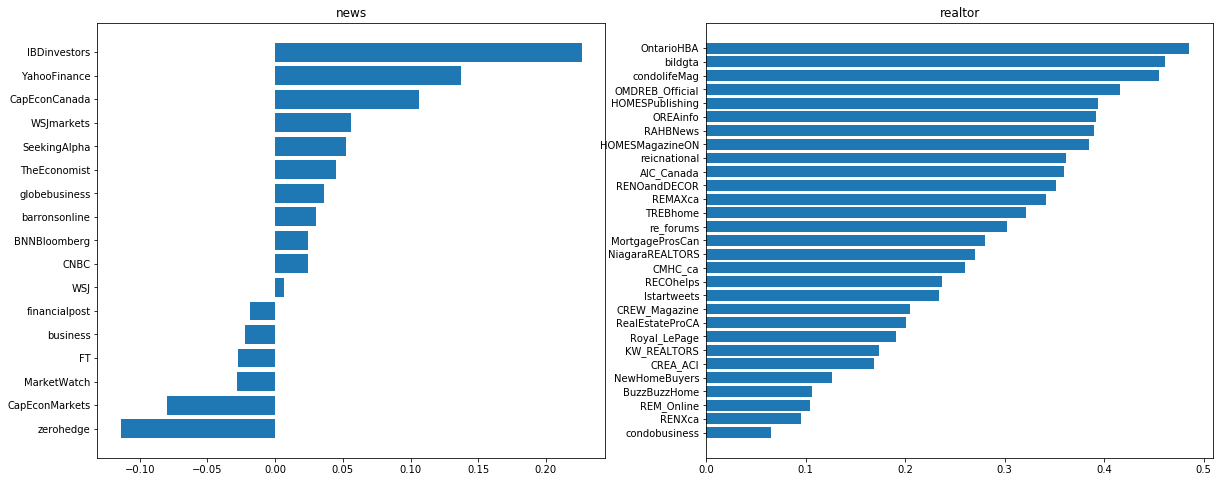

In [29]:
groupfig = plt.figure(figsize=(20,8))
fn = groupfig.add_subplot(121)
fn = sent_ingroup(news_recent)
fr = groupfig.add_subplot(122)
fr = sent_ingroup(realtor_recent)
axes = groupfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

## Price

In [30]:
df_pg = df_p.groupby(by=['city','proptype']).median().reset_index()

In [31]:
df_pg.columns = ['city','proptype','median_ask']

In [32]:
df_ppivot = df_pg.pivot(index='proptype',columns='city',values='median_ask')
df_ppivot

city,Aurora,Burlington,Hamilton,Markham,Milton,Mississauga,Newmarket,Oakville,Oshawa,Pickering,Richmond Hill,Toronto,Vaughan
proptype,,,,,,,,,,,,,
Apartment,"687,000","410,950","375,000","549,900",nan,"464,950",nan,"594,900",nan,nan,"515,400","624,500","559,500"
Bungalow,"2,190,000","897,000","494,350","1,188,999","1,199,750","1,012,400","799,000","1,099,000","554,900","2,020,000","1,253,800","850,000","1,514,900"
Detached,"1,158,000","979,500","562,000","1,339,400","877,950","1,267,500","876,950","1,414,450","619,900","894,450","1,459,444","1,293,000","1,399,450"
Loft,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"796,000",nan
Semi-Detached,nan,nan,"449,450","993,950",nan,"772,450",nan,nan,"624,450",nan,nan,"899,900","864,450"
Townhouse,"790,500","599,994","517,450","799,000","599,950","666,950","722,445","789,000","459,450","519,939","876,400","704,500","859,000"


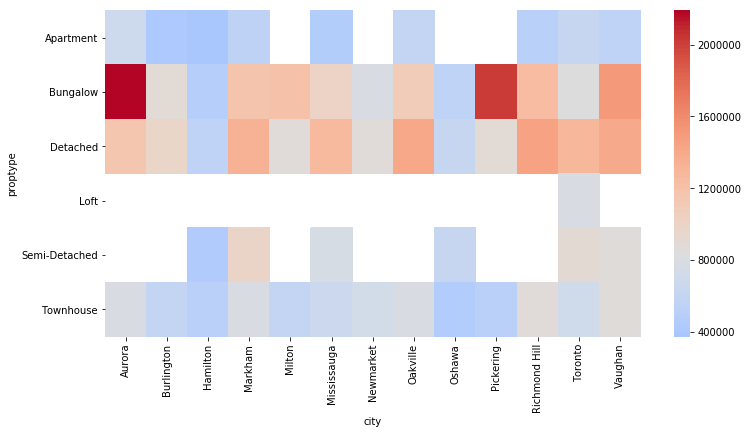

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
sns_plot=sns.heatmap(data=df_ppivot,cmap="coolwarm",center=df_ppivot.mean(axis=1).mean())

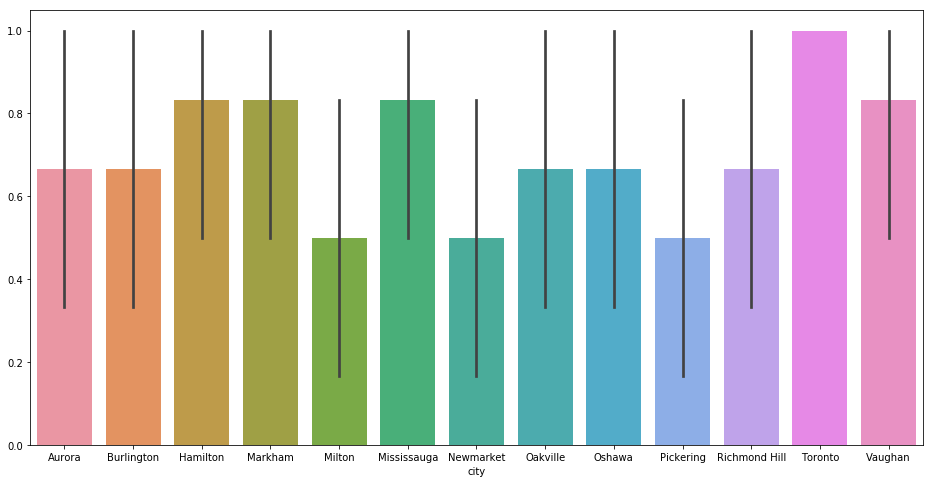

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data= df_ppivot.notnull())